<a href="https://colab.research.google.com/github/hgisaac/imersao_dados_alura/blob/main/Resumo_Imers%C3%A3o_Dados_4_Alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumo da Imersão Dados 4 Alura

Nesta 4ª edição, tivemos como assunto a exploração de dados sobre vendas de imóveis da cidade de São Paulo para prever o valor de novos imóveis, que no contexto de empresas financeiras podem ser usados como garantia de empréstimo.

Este projeto está organizado em seções que correspondem ao processo de exploração da base de dados, tratamento e análise dos dados e criação de um modelo de aprendizagem de máquina para prever o valor de imóveis.

## Sumário

1. Análise exploratória da base de dados de vendas de imóveis
2. Junção das bases de dados demográficos do IBGE e da base de dados geográficos dos endereços de São Paulo
3. Criação do modelo de aprendizagem de máquina
4. Conclusões

## Instalação e configuração do ambiente de desenvolvimento

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 46.6 MB/s 
     |████████████████████████████████| 16.7 MB 25.7 MB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1 Análise exploratória da base de dados de vendas de imóveis

A base de dados inicial foi preparada pelos instrutores a partir de uma base disponível na plataforma [Kaggle](https://www.kaggle.com/datasets/kaggleshashankk/house-price-data-of-sao-paulo).

In [ ]:
url = 'https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv'
dados = pd.read_csv(url)

Começamos a exploração consultando as informações gerais da base.

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


Podemos observar que a base possui 10.008 linhas referentes aos anúncios de imóveis e 8 colunas referentes à Rua, Bairro, Cidade, Metragem, Quartos, Banheiros, Vagas e Valor.

Uma visualização simples que podemos fazer é a quantidade de anúncios por bairro em um gráfico de barras. Como a quantidade de bairros é grande, podemos selecionar os 10 bairros com a maior quantidade de anúncios.

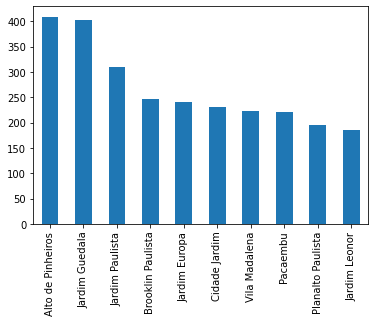

In [ ]:
numero_imoveis_bairro = dados['Bairro'].value_counts()
numero_imoveis_bairro.head(10).plot.bar()

Descobrimos que entre os 10 bairros com mais anúncios a quantidade de anúncios ficou em entre de 200 e 400, o que pode ser uma quantidade suficiente para analisarmos os valores dos anúncios.

Apesar de a base possuir uma coluna referente ao valor do aúncio, não conseguimos realizar cálculos diretamente nela porque existem partes dos valores dessa coluna que são textos, como o R$ ou a marcação do tipo de anúncio (por dia, por mês). Desse modo, precisamos separar cada uma dessas partes e podemos armazená-las em outras colunas.

In [ ]:
dados[['Moeda', 'Valor_anuncio', 'Tipo_anuncio']] = dados['Valor'].str.split(expand=True)
dados.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Moeda,Valor_anuncio,Tipo_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,R$,7.000.000,None
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,R$,3.700.000,None
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,R$,380.000,None
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000,R$,685.000,None
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,R$,540.000,None


Existem registros de imóveis que não apresentam o tipo de anúncio. Esses registros representam as vendas efetivas dos imóveis, sendo úteis para analisar os valores praticados no mercado. Para isso, filtramos a base onde a coluna de tipo de anúncio tinha valores vazios.

In [ ]:
dados_vendas = dados[dados['Tipo_anuncio'].isnull()].drop('Tipo_anuncio', axis=1)
dados_vendas.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Moeda,Valor_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,R$,7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,R$,3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,R$,380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000,R$,685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,R$,540.000


Após essa filtragem, podemos verificar novamente as informações dessa nova base que criamos.

In [ ]:
dados_vendas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9156 entries, 0 to 10007
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Rua            6107 non-null   object
 1   Bairro         9146 non-null   object
 2   Cidade         9156 non-null   object
 3   Metragem       9156 non-null   int64 
 4   Quartos        9156 non-null   int64 
 5   Banheiros      9156 non-null   int64 
 6   Vagas          9156 non-null   int64 
 7   Valor          9156 non-null   object
 8   Moeda          9156 non-null   object
 9   Valor_anuncio  9156 non-null   object
dtypes: int64(4), object(6)
memory usage: 786.8+ KB


Agora temos duas colunas com os valores dos anúncios, a original (Valor) e a que possui apenas números (Valor_anuncio). Entretanto, notamos que os valores da coluna Valor_anuncio ainda não são realmente números (indicado pelo tipo *object*) por conta de apresentarem pontos de separação de milhar. Para isso, devemos remover esses pontos e então converter para número "decimal" (*float*).

In [ ]:
dados_vendas['Valor'] = dados_vendas['Valor_anuncio'].str.replace('.', '').astype(float)
dados_vendas.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Moeda,Valor_anuncio
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,R$,7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,R$,3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,R$,380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,R$,685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,R$,540.000


Após esses tratamentos, podemos remover as colunas geradas pela separação da coluna original com os valores dos anúncios.

In [ ]:
dados_vendas = dados_vendas.drop(['Moeda', 'Valor_anuncio'], axis=1)
dados_vendas.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00


Com isso, podemos conferir as principais estatísticas de contagem, média, desvio padrão, quartis e valores máximos e mínimos das colunas numéricas que temos na nossa base.

In [ ]:
dados_vendas.describe()

,Metragem,Quartos,Banheiros,Vagas,Valor
count,9156.00,9156.00,9156.00,9156.00,9156.00
mean,434.42,3.45,3.80,3.96,3052202.96
std,7856.42,1.05,1.97,2.60,3944208.19
min,10.00,1.00,1.00,1.00,13000.00
25%,168.00,3.00,2.00,2.00,890000.00
50%,276.00,3.00,4.00,4.00,1800000.00
75%,450.00,4.00,5.00,5.00,3500000.00
max,750000.00,16.00,40.00,50.00,65000000.00


Como estamos trabalhando dados de imóveis, é de se esperar que os valores de anúncio e venda sejam consideravelmente altos, podendo chegar a milhões de reais. Nesse sentido, para melhorar nossa visualização da distribuição dos valores, podemos ajustar a escala dos números para milhões.

In [ ]:
dados_vendas['Valor_milhoes'] = dados_vendas['Valor'].apply(lambda x: x / 1000000)
dados_vendas['Valor_milhoes'].head()

0   7.00
1   3.70
2   0.38
3   0.69
4   0.54
Name: Valor_milhoes, dtype: float64

Em seguida, criamos um gráfico de distribuição (histograma) que mostra, no eixo vertical, quantos imóveis existem na nossa base em relação ao valor de venda, no eixo horizontal.

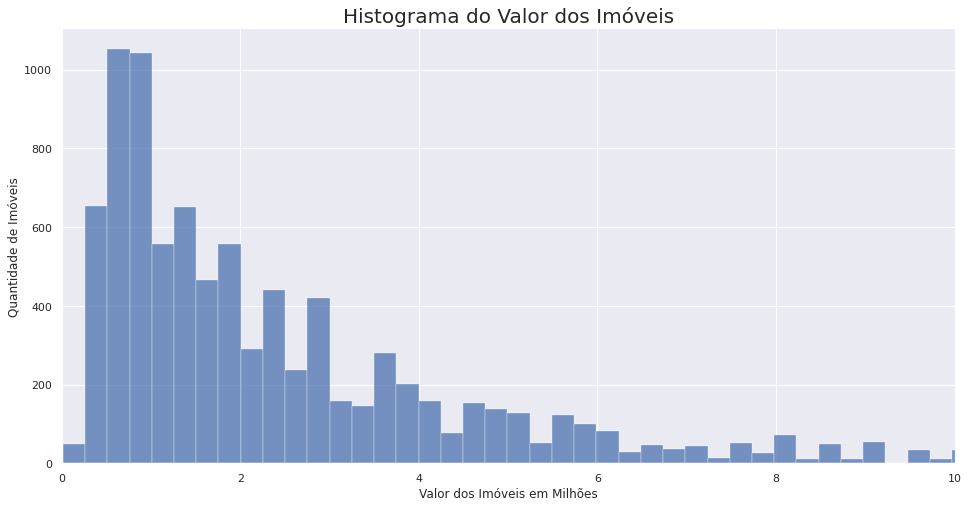

In [ ]:
sns.set()
plt.figure(figsize=(16, 8))
ax = sns.histplot(data=dados_vendas, x='Valor_milhoes')
ax.set_title('Histograma do Valor dos Imóveis', {'fontsize': 20})
ax.set_ylabel('Quantidade de Imóveis')
ax.set_xlabel('Valor dos Imóveis em Milhões')
plt.xlim((0, 10))
plt.show()

Com esse gráfico é possível perceber que a maioria dos valores de imóveis está em uma faixa de até 2 milhões de reais. Além disso, a partir de 6 milhões a quantidade de imóveis fica estável e se estende até os valores mais altos.

Agora que temos uma noção dos valores dos imóveis, podemos dar um passo a mais na análise e criar uma nova variável do valor por metro quadrado e visualizar a média desses valores por bairro.

A forma mais direta de realizarmos esse cálculo é dividindo o valor de venda pelo metro² de cada imóvel.

In [ ]:
dados_vendas['Valor_m2'] = dados_vendas['Valor'] / dados_vendas['Metragem']
dados_vendas.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00


Em seguida agrupamos os valores por bairro aplicando o cálculo de média.

In [ ]:
dados_vendas.groupby('Bairro').mean().head()

,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
Bairro,,,,,,,
Aclimação,246.16,3.27,3.04,2.91,1763200.01,1.76,7656.17
Alto da Boa Vista,418.88,4.12,5.12,4.62,2391250.00,2.39,5849.57
Alto da Lapa,299.25,3.15,3.85,4.00,2083168.75,2.08,7606.73
Alto da Mooca,270.05,3.30,2.60,3.65,1184170.00,1.18,5691.74
Alto de Pinheiros,429.85,3.94,4.83,4.95,4782698.96,4.78,11269.98


Ao realizar uma agregação, é importante considerar a forma como é feita esta agregação para que não seja realizado cálculos inadequados como uma média de médias. Talvez a forma mais correta de se alcançar a média do valor do metro² por bairro seja primeiro somar todos os valores de vendas e metragens para então dividir um pelo outro.

In [ ]:
dados_bairro = dados_vendas.groupby('Bairro').sum()
dados_bairro.head()

,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
Bairro,,,,,,,
Aclimação,19447,258,240,230,139292801.00,139.29,604837.39
Alto da Boa Vista,3351,33,41,37,19130000.00,19.13,46796.55
Alto da Lapa,23940,252,308,320,166653500.00,166.65,608538.25
Alto da Mooca,5401,66,52,73,23683400.00,23.68,113834.80
Alto de Pinheiros,158616,1453,1782,1827,1764815915.00,1764.82,4158622.61


In [ ]:
dados_bairro['Valor_m2'] = dados_bairro['Valor'] / dados_bairro['Metragem']
dados_bairro.head()

,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
Bairro,,,,,,,
Aclimação,19447,258,240,230,139292801.00,139.29,7162.69
Alto da Boa Vista,3351,33,41,37,19130000.00,19.13,5708.74
Alto da Lapa,23940,252,308,320,166653500.00,166.65,6961.30
Alto da Mooca,5401,66,52,73,23683400.00,23.68,4385.00
Alto de Pinheiros,158616,1453,1782,1827,1764815915.00,1764.82,11126.34


Selecionando o bairro Aclimação para comparar os dois métodos, podemos notar que realmente existe uma diferença nos valores finais.

In [ ]:
print('Divisão depois média:', dados_vendas.groupby('Bairro').mean().head()['Valor_m2']['Aclimação'])
print('Soma depois divisão:', dados_bairro['Valor_m2']['Aclimação'])

Divisão depois média: 7656.169464859427
Soma depois divisão: 7162.688383812413


Utilizando o segundo método de cálculo do valor do metro² por bairro, podemos filtrar os 10 bairros mais frequêntes para verificarmos seus valores de metros².

In [ ]:
top_10_bairros_contagem = dados_vendas['Bairro'].value_counts()[:10].index

In [ ]:
# o @ substitui por variáveis externas
dados_bairro.reset_index(inplace=True)
dados_top_bairros = dados_bairro.query('Bairro in @top_10_bairros_contagem').sort_values('Valor_m2', ascending=False)
dados_top_bairros

,Bairro,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
155,Jardim Europa,118898,795,993,1056,2414172900.00,2414.17,20304.57
227,Jardim Paulista,130283,1028,1231,1171,2136081000.00,2136.08,16395.70
4,Alto de Pinheiros,158616,1453,1782,1827,1764815915.00,1764.82,11126.34
57,Cidade Jardim,132220,789,1008,1172,1164210900.00,1164.21,8805.10
564,Vila Madalena,66250,739,786,712,583253030.00,583.25,8803.82
338,Pacaembu,100285,774,889,1028,867956500.00,867.96,8654.90
19,Brooklin Paulista,70002,778,862,832,475796789.00,475.80,6796.90
187,Jardim Leonor,97141,697,941,902,646326369.00,646.33,6653.49
396,Planalto Paulista,59250,636,768,713,374907000.00,374.91,6327.54
168,Jardim Guedala,972212,1443,2027,2161,1801165587.00,1801.17,1852.65


Com isso, criamos um gráfico de barras do valor/metro², no eixo vertical, por bairro, no eixo horizontal.

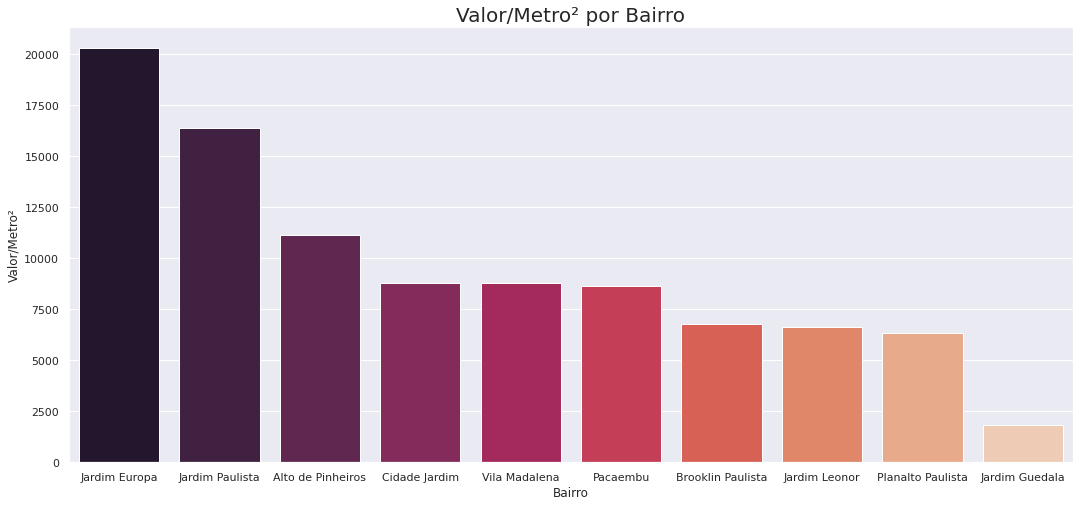

In [ ]:
sns.set()
plt.figure(figsize=(18, 8))
ax = sns.barplot(
    x='Bairro',
    y='Valor_m2',
    data=dados_top_bairros,
    palette="rocket")
ax.set_title("Valor/Metro² por Bairro", {"fontsize": 20})
ax.set_ylabel("Valor/Metro²")
ax.set_xlabel("Bairro")
plt.show()

Podemos notar que os bairros Jardim Europa, Jardim Paulista e Alto de Pinheiros estão entre os metros² mais caros da nossa base, com valores acima de R$ 10.000,00.

# 2 Junção das bases de dados demográficos do IBGE e da base de dados geográficos dos endereços de São Paulo

Até o momento exploramos uma pequena base de dados. Para avançarmos no nosso desafio de tentar prever o valor de um imóvel precisamos enriquecer nossa base com outras que nos forneçam variáveis relacionadas ao nosso problema.

Tratando-se de informações sobre imóveis em uma determinada cidade, podemos trazer dados demográficos do IBGE como a renda das famílias em uma região para relacionarmos, por exemplo, com a variável de bairro da nossa base. Os instrutores selecionaram uma base do censo 2010 do IBGE com a segmentação de São Paulo.

In [ ]:
ibge_url = "https://gist.githubusercontent.com/tgcsantos/85f8c7b0a2edbc3e27fcad619b37d886/raw/a4954781e6bca9cb804062a3eea0b3b84679daf4/Basico_SP1.csv"
ibge_sp = pd.read_csv(
    ibge_url,
    encoding='ISO-8859-1',
    sep=';',
    thousands='.',
    decimal=',')
ibge_sp.dropna(how='all', axis=1, inplace=True)
ibge_sp.head()

,Cod_setor,Cod_Grandes Regiï¿½es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,355030801000001,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.01,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86
1,355030801000002,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,2.98,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94
2,355030801000003,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.31,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74
3,355030801000004,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.16,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24
4,355030801000005,3,Regiï¿½o Sudeste,35,Sï¿½o Paulo,3515,Metropolitana de Sï¿½o Paulo,35061,Sï¿½o Paulo,20,...,3.14,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85


In [ ]:
ibge_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cod_setor              18363 non-null  int64  
 1   Cod_Grandes Regiï¿½es  18363 non-null  int64  
 2   Nome_Grande_Regiao     18363 non-null  object 
 3   Cod_UF                 18363 non-null  int64  
 4   Nome_da_UF             18363 non-null  object 
 5   Cod_meso               18363 non-null  int64  
 6   Nome_da_meso           18363 non-null  object 
 7   Cod_micro              18363 non-null  int64  
 8   Nome_da_micro          18363 non-null  object 
 9   Cod_RM                 18363 non-null  int64  
 10  Nome_da_RM             18363 non-null  object 
 11  Cod_municipio          18363 non-null  int64  
 12  Nome_do_municipio      18363 non-null  object 
 13  Cod_distrito           18363 non-null  int64  
 14  Nome_do_distrito       18363 non-null  object 
 15  Co

Apesar de a base do IBGE possuir informações sobre os bairros, que poderiam ser relacionados com nossa base de imóveis, a definição dos nomes dos bairros ou até mesmo se existem possíveis agrupamentos inviabiliza essa abordagem.

Nesse tipo de situação, devemos buscar outra fonte de dados que nos ajude a conectar as informações de forma correta. Com isso, incluímos uma terceira base de dados referentes aos dados geográficos dos endereços do Brasil.

In [ ]:
enderecos = pd.read_csv('/content/drive/MyDrive/Projetos/Ciência de Dados/imersao_dados_alura_2022/enderecos.csv')
enderecos.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
0,Rua,Armando Silveira,Rua Armando Silveira,NaN,Divisa,Santana do Livramento,RS,97573200.00,-30.88,-55.55
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45
2,Rua,Prefeito Agenor Barcelos Feio,Rua Prefeito Agenor Barcelos Feio,NaN,Registro,Santana do Livramento,RS,97571090.00,-30.86,-55.56
3,Rua,Sebastião Gomes,Rua Sebastião Gomes - até 59/60,59,Registro,Santana do Livramento,RS,97571374.00,-30.86,-55.55
4,Rua,Marquês do Alegrete,Rua Marquês do Alegrete,NaN,Parque das Águas,Santana do Livramento,RS,97571500.00,-30.86,-55.55


Em seguida, filtramos os endereços apenas do estado de São Paulo.

In [ ]:
enderecos_sp = enderecos.query('sigla_uf == "SP"')
enderecos_sp.head()

,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45
413269,Rua,A,Rua A,NaN,Jardim Glória,Americana,SP,13468220.00,-22.76,-47.34
413270,Rua,A,Rua A,NaN,Jardim São Roque,Americana,SP,13469414.00,-22.74,-47.35
413271,Rua,A,Rua A,NaN,Iate Clube de Campinas,Americana,SP,13475620.00,-22.74,-47.33
413272,Rua,João Bandini,Rua João Bandini,NaN,Jardim Miriam,Americana,SP,13469072.00,-22.74,-47.35


Como as informações de bairro, nesse contexto, não atendem nossa necessidade, precisamos usar as informações de rua para conectar as bases. Para isso, devemos garantir que as informações estejam no mesmo formato. Nesse caso, devemos juntar o tipo e o nome do logradouro na base de endereços, além de formatar o texto para minúsculo.

In [ ]:
enderecos_sp['rua'] = enderecos_sp['tipo_logr'] + ' ' + enderecos_sp['logr_nome']
enderecos_sp['rua'] = enderecos_sp['rua'].str.lower().str.strip()
enderecos_sp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tipo_logr,logr_nome,logr_compl,numero,bairro,nome_localidade,sigla_uf,cep,latitude,longitude,rua
1,Rua,João Antônio Vasconcelos,Rua João Antônio Vasconcelos - até 627/628,627,Amizade,Araçatuba,SP,16074320.00,-21.19,-50.45,rua joão antônio vasconcelos
413269,Rua,A,Rua A,NaN,Jardim Glória,Americana,SP,13468220.00,-22.76,-47.34,rua a
413270,Rua,A,Rua A,NaN,Jardim São Roque,Americana,SP,13469414.00,-22.74,-47.35,rua a
413271,Rua,A,Rua A,NaN,Iate Clube de Campinas,Americana,SP,13475620.00,-22.74,-47.33,rua a
413272,Rua,João Bandini,Rua João Bandini,NaN,Jardim Miriam,Americana,SP,13469072.00,-22.74,-47.35,rua joão bandini


Na base de imóveis, também extraímos apenas o tipo e nome do logradouro e formatamos para minúsculo.

In [ ]:
dados_vendas['Rua'] = dados_vendas['Rua'].str.extract(r'(^[\w ]+)')
dados_vendas['Rua'] = dados_vendas['Rua'].str.lower().str.strip()
dados_vendas.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2
0,avenida itacira,Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00
1,rua aurelia perez alvarez,Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68
2,rua alba valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68
4,rua tobias barreto,Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00


Após a normalização dos dados, podemos mesclar a base de vendas dos imóveis com as informações geográficas dos endereços.

In [ ]:
dados_geo = pd.merge(left=dados_vendas, right=enderecos_sp[['rua', 'cep', 'latitude', 'longitude']],
                     how='left', left_on='Rua', right_on='rua').drop_duplicates(subset=dados_vendas.columns).query('cep > 0')
dados_geo.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2,rua,cep,latitude,longitude
0,avenida itacira,Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00,avenida itacira,11443160.00,-23.98,-46.20
5,rua aurelia perez alvarez,Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68,rua aurelia perez alvarez,4642020.00,-23.64,-46.69
6,rua alba valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00,rua alba valdez,4845200.00,-23.75,-46.70
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68,NaN,18125000.00,-23.53,-47.26
26,rua tobias barreto,Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00,rua tobias barreto,13474663.00,-22.70,-47.29


Para conseguirmos juntar a base de imóveis e informações geográficas com o censo do IBGE, precisamos antes dos dados geográficos dos setores censitários, que o IBGE define como regiões com padrões demográficos em comum.

In [ ]:
setor_censo = gpd.read_file('/content/drive/MyDrive/Projetos/Ciência de Dados/imersao_dados_alura_2022/sp_setores_censitarios/35SEE250GC_SIR.shp')
setor_censo_sp = setor_censo[setor_censo.NM_MUNICIP == 'SÃO PAULO']
setor_censo_sp.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
42322,109347.00,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5..."
42323,109348.00,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((-46.51888 -23.57967, -46.51908 -23.5..."
42324,109349.00,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((-46.52015 -23.58105, -46.52026 -23.5..."
42325,109350.00,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((-46.52140 -23.57992, -46.52144 -23.5..."
42326,109351.00,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((-46.52371 -23.58185, -46.52384 -23.5..."


Considerando que estamos tentando relacionar uma coordenada geográfica com uma região da cidade, o setor censitário, precisamos fazer uso do geometria para localizar um ponto (longitude, latitude) em uma figura poligonal (setor censitário). Com base nesse ponto de referência, podemos associar aos dados geográficos da nossa base de vendas de imóveis.

In [ ]:
dados_geo['Point'] = ''
for i in dados_geo.index:
    dados_geo['Point'][i] = Point(dados_geo['longitude'][i], dados_geo['latitude'][i])

dados_geo['setor_censo'] = dados_geo['Point'][:10].map(
    lambda x: setor_censo_sp.loc[setor_censo_sp.contains(x), 'CD_GEOCODI'].values
).str[0].astype(float)
dados_geo.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_milhoes,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo
0,avenida itacira,Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00,avenida itacira,11443160.00,-23.98,-46.20,POINT (-46.2013172 -23.975993),NaN
5,rua aurelia perez alvarez,Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68,rua aurelia perez alvarez,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00
6,rua alba valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00,rua alba valdez,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00
7,NaN,Jardim Morumbi,São Paulo,310,3,2,4,685000.00,0.69,2209.68,NaN,18125000.00,-23.53,-47.26,POINT (-47.2550228 -23.5310431),NaN
26,rua tobias barreto,Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00,rua tobias barreto,13474663.00,-22.70,-47.29,POINT (-47.2944609 -22.6989009),NaN


Alguns tratamentos na base ficaram de fora durante as aulas, sendo disponibilizada a base de dados geográficos com os tratamentos realizados pelos instrutores.

In [ ]:
dados_geo_limpo = pd.read_csv('/content/drive/MyDrive/Projetos/Ciência de Dados/imersao_dados_alura_2022/dados_geo.csv')
dados_geo_limpo.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_anuncio,Tipo_anuncio,Valor_mm,Valor_m2,rua,cep,latitude,longitude,Point,setor_censo
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,7000000.00,NaN,7.00,7000.00,Avenida Itacira,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,3700000.00,NaN,3.70,7459.68,Rua Aurelia Perez Alvarez,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,380000.00,NaN,0.38,3040.00,Rua Alba Valdez,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,540000.00,NaN,0.54,5400.00,Rua Tobias Barreto,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000,1980000.00,NaN,1.98,4500.00,Rua Graham Bell,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00


Com a associação dos dados de vendas com os dados geográficos já localizados no setor censitário, podemos finalmente mesclar com o censo do IBGE.

In [ ]:
dados_vendas_censo = pd.merge(left=dados_geo_limpo, right=ibge_sp, how='left', left_on='setor_censo', right_on='Cod_setor')
dados_vendas_censo.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_anuncio,Tipo_anuncio,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000,7000000.00,NaN,...,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000,3700000.00,NaN,...,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000,380000.00,NaN,...,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000,540000.00,NaN,...,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,R$ 1.980.000,1980000.00,NaN,...,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46


# 3 Criação do modelo de aprendizagem de máquina

Chegamos no momento tão esperado. Temos uma base de dados enriquecida com diversas variáveis e podemos partir para a criação do modelo que tentará prever o valor de imóveis.

É importante levarmos em consideração que nem todas as colunas serão úteis para criação do modelo. Embora ainda não tenhamos noção de como essas variáveis se relacionam, podemos fazer uma pré seleção daquilo que pode ser relevante para nosso problema. Além das variáveis da base de imóveis foram mantidas as variáveis de latitude e longitude da base de endereço e as principais variáveis demográficas do censo do IBGE.

In [ ]:
dados_vendas_censo = dados_vendas_censo[['Rua', 'Bairro', 'Cidade', 'Metragem', 'Quartos', 'Banheiros', 'Vagas',
       'Valor_anuncio', 'Valor_mm', 'Valor_m2', 'latitude', 'longitude', 'Situacao_setor', 'V001',
       'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008', 'V009', 'V010',
       'V011', 'V012']].dropna()
dados_vendas_censo.drop(dados_vendas_censo.query('Valor_anuncio > 30000000 | Valor_anuncio < 100000').index, inplace=True)
dados_vendas_censo.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor_anuncio,Valor_mm,Valor_m2,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7.00,7000.00,...,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,3.70,7459.68,...,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,0.38,3040.00,...,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,0.54,5400.00,...,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.00,1.98,4500.00,...,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46


Em seguida podemos analisar o nível de relacionamento entre as variáveis. Existe diversas formas de realizar esse tipo de análise, envolvendo métricas e métodos específicos para a pergunta que queremos responder.

Uma dessas análises é calcular o índice de correlação entre cada variável. O resultado de uma correlação é um número entre -1 (quando a correlação é inversamente proporcional) e 1 (quando a correlação é diretamente proporcional).

Para visualizarmos a correlação entre as variáveis da nossa base de dados, criamos um gráfico de mapa de calor. Nesse tipo de gráfico, os eixos vertical e horizontal são espelhados, ou seja, mostram as mesmas variáveis. Com isso, podemos identificar e comparar os índices entre todas as variáveis.

Text(0.5, 1.0, 'Correlação')

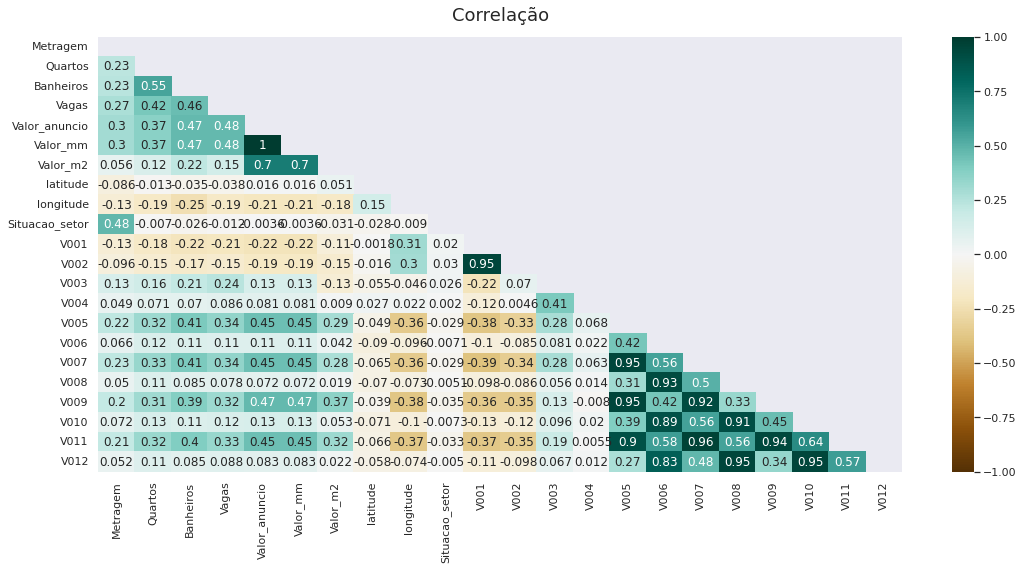

In [ ]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(dados_vendas_censo.corr(), dtype=bool))
heatmap = sns.heatmap(dados_vendas_censo.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação', fontdict={'fontsize': 18}, pad=16)

Estamos buscando variáveis que apresentem uma correlação próxima de -1 ou 1. Percebemos que as principais variáveis com essa característica são a metragem, quartos, banheiros, vagas, V001, V005, V007, V009 e V011.

Após selecionar as variáveis, definimos quais serão as "preditoras" (variáveil x) e qual é a "predita" (variável y). Em seguida, devemos separar um conjunto de dados para realizar o treino do modelo e outro para testar se o modelo está prevendo de forma adequada o valor dos imóveis.

Por fim, foi escolhido duas métricas estatísticas de desempenho do modelo, o [erro médio absoluto](https://en.wikipedia.org/wiki/Mean_absolute_error) e o [R²](https://pt.wikipedia.org/wiki/R%C2%B2).

In [ ]:
x = dados_vendas_censo[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001', 'V005', 'V007', 'V009', 'V011']]
y = dados_vendas_censo['Valor_anuncio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=54)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_predict_test = lr.predict(x_test)
y_predict_train = lr.predict(x_train)

mae_test = mean_absolute_error(y_test, y_predict_test)
r2_test = r2_score(y_test, y_predict_test)

mae_train = mean_absolute_error(y_train, y_predict_train)
r2_train = r2_score(y_train, y_predict_train)

Ambas as estatísticas escolhidas servem para indicar o quão bom nosso modelo está sendo nas predições, mas cada uma tem uma interpretação diferente. Enquanto com erro médio absoluto quanto menor o resultado melhor o modelo está desempenhando, com o R² o contrário é o desejado.

In [ ]:
print('MAE test:', mae_test)
print('R² test:', r2_test)
print('MAE train:', mae_train)
print('R² train:', r2_train)

MAE test: 1346021.4510240962
R² test: 0.387184077109599
MAE train: 1368585.0616045955
R² train: 0.40229236906196086


Podemos notar que com os dados de teste o modelo se saiu levemente melhor no erro médio absoluto, mas levemente pior no R². Isso indica que nosso modelo não está desempenhando bem, tendo um resultado abaixo do esperado com os dados que ele mesmo foi treinado.

Ainda assim, podemos comparar os valores reais, no eixo horizontal, com as predições, no eixo vertical, em um gráfico de dispersão e conferir visualmente como o modelos se comporta.

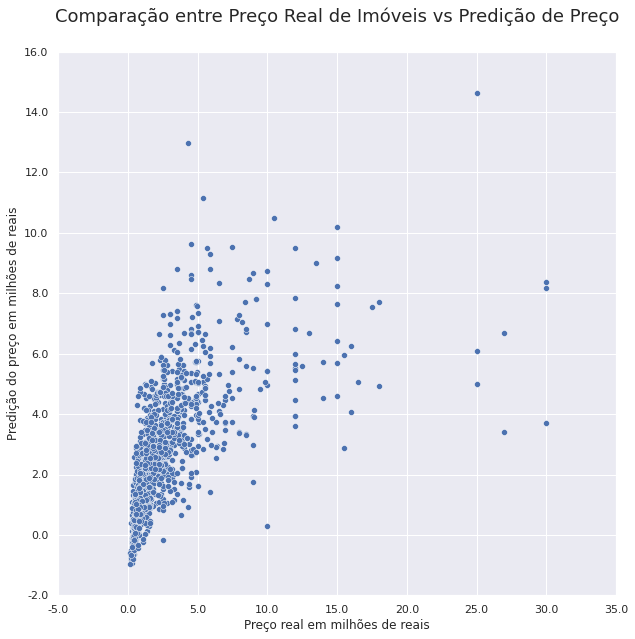

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x=y_test, y=y_predict_test)
ax.set_title('Comparação entre Preço Real de Imóveis vs Predição de Preço', fontdict={'fontsize': 18}, pad=30)
ax.set_ylabel("Predição do preço em milhões de reais")
ax.set_xlabel("Preço real em milhões de reais")
plt.yticks(ax.get_yticks(), ax.get_yticks() / 1000000)
plt.xticks(ax.get_xticks(), ax.get_xticks() / 1000000)
plt.show()

# 4 Conclusões

Embora o modelo linear de aprendizagem de máquina não tenha atingido bons resultados nas métricas utilizadas, é possível notar que para um conjunto reduzido de imóveis com valores baixo a dispersão dos dados foi menor em comparação aos imóveis com valores muito altos. Isso pode ter ocorrido devido a maior quantidade de imóveis na base de dados com essa faixa de preço.

É importante destacar que existem diversos fatores que influenciam o desempenho de um modelo, indo desde a escolha das fontes de dados, seu tratamento adequado até a escolha e parametrização dos algoritmos. Com isso, os principais pontos de melhoria que este projeto poderia ter são referentes às variáveis utilizadas para o treinamento do modelo, o tamanho relativamente pequeno da base de dados e os procedimentos de tratamento dos dados.

# Agradecimentos

Muito obrigado aos instrutores [Thiago Gonçalves](https://www.linkedin.com/in/thiago-gon%C3%A7alves-santos/), [Vivian Yamassaki](https://www.linkedin.com/in/vivianyamassaki/) e [Paulo Silveira](https://www.linkedin.com/in/paulosilveira) por prepararem, conduzirem e motivarem o estudo durante esta imersão e a toda a equipe da [Alura](https://alura.com.br/) por tornarem isso possível.